## Load Models

In [7]:
sig_types = [['2-ASK', ['ask', 2], 0],
             ['4-ASK', ['ask', 4], 1],
             ['8-ASK', ['ask', 8], 2],
             ['BPSK', ['psk', 2], 3],
             ['QPSK', ['psk', 4], 4],
             ['16-QAM', ['qam', 16], 5],
             ['Tone', ['constant'], 6],
             ['P-FMCW', ['p_fmcw'], 7]]
num_classes = len(sig_types)
sig_names = [i[0] for i in sig_types]

device = "cuda" if torch.cuda.is_available() else "cpu"
print('Using device', device)

TEAM1_OBS_INT = 2048
TEAM2_OBS_INT = 1024
TEAM3_OBS_INT = 512
TEAM4_OBS_INT = 256

team1_model = Team1Model(num_classes)
team1_model.load_state_dict(torch.load('../data/summer_models/team1_model.pt', map_location=torch.device('cpu')))
team1_model.eval()
team1_model.to(device)
print ("loaded team1")

team2_model = Team2Model(num_classes)
team2_model.load_state_dict(torch.load('../data/summer_models/team2_model.pt', map_location=torch.device('cpu')))
team2_model.eval()
team2_model.to(device)
print ("loaded team2")
team3_model = Team3Model(num_classes)
team3_model.load_state_dict(torch.load('../data/summer_models/team3_model.pt', map_location=torch.device('cpu')))
team3_model.eval()
team3_model.to(device)
print ("loaded team3")
team4_model = Team4Model(num_classes)
team4_model.load_state_dict(torch.load('../data/summer_models/team4_model.pt', map_location=torch.device('cpu')))
team4_model.eval()
team4_model.to(device)
print ("loaded team4")

# Load regular fused model
reg_fused_model = xgb.XGBClassifier(tree_method="hist")
reg_fused_model.load_model('../data/summer_models/baseline_fused_2tl.json')
print('loaded baseline fused model')

# Load RL fused model
rl_fused_model = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2, n_estimators=5)
rl_fused_model.load_model('../data/summer_models/rl_fused_2tl.json')
with open('../data/summer_models/rl_feature_idxes_2tl.pkl', 'rb') as f:
    rl_feature_idxes = pickle.load(f)
print('loaded RL fused model')

# Load RFE fused model
rfe_fused_model = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
rfe_fused_model.load_model('../data/summer_models/rfe_fused_2tl.json')
with open('../data/summer_models/rfe_feature_idxes_2tl.pkl', 'rb') as f:
    rfe_feature_idxes = pickle.load(f)
print('loaded RFE fused model')

Using device cuda


/tmp/ipykernel_440/1760738631.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  team1_model.load_state_dict(torch.load('../data/summer_models/team1_model.pt', map_locatio

loaded team1
loaded team2
loaded team3


/tmp/ipykernel_440/1760738631.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  team2_model.load_state_dict(torch.load('../data/summer_models/team2_model.pt', map_locatio

loaded team4
loaded baseline fused model
loaded RL fused model
loaded RFE fused model


In [8]:
team1_test_dir = os.path.join('../data/dataset', 'team1', 'test')
team2_test_dir = os.path.join('../data/dataset', 'team2', 'test')
team3_test_dir = os.path.join('../data/dataset', 'team3', 'test')
team4_test_dir = os.path.join('../data/dataset', 'team4', 'test')

team1_selected_layer = getattr(team1_model, "fc3")
team2_selected_layer = getattr(team2_model, "fc1")
team3_selected_layer = getattr(team3_model, "fc3")
team4_selected_layer = getattr(team4_model, "fc2")

NUM_FEATS_T1 = 65
NUM_FEATS_T2 = 512
NUM_FEATS_T3 = 64
NUM_FEATS_T4 = 256

num_batches = 1
CHUNK_SIZE = 5000
num_examples = num_batches * CHUNK_SIZE

## Helper functions

In [9]:
MODELS_OBS_INT = 2048
def load_data(channel_path, batch_size, num_batches, num_train_examples, data_obs_int):
    training_data = np.zeros((num_train_examples, 1, 2, MODELS_OBS_INT), dtype=np.float32)

    last_index = 0
    for k in range(num_batches):
        # This is used if we have a labeldata folder that stores class labels
        label_df = pd.read_csv(f"{channel_path}/labeldata/example_{k + 1}.csv")

        num_nans = 0
        iq_file_name = f"{channel_path}/iqdata/example_{k + 1}.dat"
        iq_data = np.fromfile(iq_file_name, np.csingle)
        iq_data = np.reshape(iq_data, (-1, data_obs_int))  # Turn the IQ data into chunks of (chunk size) x (data_obs_int)
        for j in range(iq_data.shape[0]):
            # Check if the current row contains NaN values
            if np.isnan(np.sum(iq_data[j][:])):    
                num_nans += 1
            else:
                iq_array_norm = iq_data[j][:] / np.max(np.abs(iq_data[j][:]))  # Normalize the observation
                iq_array = np.vstack((iq_array_norm.real, iq_array_norm.imag))  # Separate into 2 subarrays - 1 with only real (in-phase), the other only imaginary (quadrature)

                # Pad the iq array with zeros to meet the observation length requirement
                # This is needed because the CNN models have a fixed input size
                iq_array = np.pad(iq_array, ((0, 0), (0, MODELS_OBS_INT - iq_array[0].size)), mode='constant', constant_values=0)

                training_data[last_index, 0, :, :] = iq_array
            last_index += 1
        
        if num_nans > 0:
            print(f'Found {num_nans} rows containing NaNs in {iq_file_name}')
    return torch.utils.data.DataLoader([training_data[i] for i in range(num_train_examples)], batch_size=batch_size, shuffle=False)

def load_labels(channel_path, batch_size, num_batches, num_train_examples, data_obs_int):
    training_labels = torch.stack([torch.nn.functional.one_hot(torch.tensor(pd.read_csv(os.path.join(channel_path, f'labeldata/example_{i+1}.csv')).iloc[:,0])) for i in range(num_batches)])
    return training_labels

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

## Plot accuracy vs SNR

Loaded data for SNR 3
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 2367.45it/s]
Team 2: 5000it [00:02, 2179.86it/s]
Team 3: 5000it [00:01, 4433.60it/s]
Team 4: 5000it [00:02, 2392.56it/s]


Loaded data for SNR 6
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2879.48it/s]
Team 2: 5000it [00:02, 2250.30it/s]
Team 3: 5000it [00:02, 2228.83it/s]
Team 4: 5000it [00:02, 2322.71it/s]


Loaded data for SNR 7
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2855.78it/s]
Team 2: 5000it [00:02, 2258.98it/s]
Team 3: 5000it [00:01, 4373.85it/s]
Team 4: 5000it [00:02, 1960.72it/s]


Loaded data for SNR 9
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2890.89it/s]
Team 2: 5000it [00:02, 2244.46it/s]
Team 3: 5000it [00:01, 4240.41it/s]
Team 4: 5000it [00:02, 1908.63it/s]


Loaded data for SNR 12
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2817.20it/s]
Team 2: 5000it [00:02, 1809.77it/s]
Team 3: 5000it [00:01, 3823.49it/s]
Team 4: 5000it [00:03, 1630.18it/s]


Loaded data for SNR 4
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2884.61it/s]
Team 2: 5000it [00:02, 2120.88it/s]
Team 3: 5000it [00:01, 4149.63it/s]
Team 4: 5000it [00:02, 2497.77it/s]


Loaded data for SNR 0
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2818.27it/s]
Team 2: 5000it [00:02, 1839.95it/s]
Team 3: 5000it [00:01, 4343.52it/s]
Team 4: 5000it [00:01, 2576.70it/s]


Loaded data for SNR 11
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2814.12it/s]
Team 2: 5000it [00:02, 2033.24it/s]
Team 3: 5000it [00:01, 4002.36it/s]
Team 4: 5000it [00:01, 2527.30it/s]


Loaded data for SNR 13
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2820.82it/s]
Team 2: 5000it [00:02, 2222.58it/s]
Team 3: 5000it [00:01, 4299.89it/s]
Team 4: 5000it [00:01, 2552.88it/s]


Loaded data for SNR 10
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2850.20it/s]
Team 2: 5000it [00:03, 1663.73it/s]
Team 3: 5000it [00:01, 4263.31it/s]
Team 4: 5000it [00:01, 2519.66it/s]


Loaded data for SNR 8
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2824.91it/s]
Team 2: 5000it [00:03, 1624.58it/s]
Team 3: 5000it [00:01, 3021.10it/s]
Team 4: 5000it [00:03, 1581.60it/s]


Loaded data for SNR 2
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2858.36it/s]
Team 2: 5000it [00:02, 2182.35it/s]
Team 3: 5000it [00:01, 2500.49it/s]
Team 4: 5000it [00:02, 2469.84it/s]


Loaded data for SNR 5
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2845.78it/s]
Team 2: 5000it [00:02, 2201.19it/s]
Team 3: 5000it [00:01, 3262.13it/s]
Team 4: 5000it [00:02, 1915.08it/s]


Loaded data for SNR 14
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2624.36it/s]
Team 2: 5000it [00:03, 1369.39it/s]
Team 3: 5000it [00:02, 2231.67it/s]
Team 4: 5000it [00:03, 1543.97it/s]


Loaded data for SNR 1
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 2308.10it/s]
Team 2: 5000it [00:02, 2167.65it/s]
Team 3: 5000it [00:01, 3844.45it/s]
Team 4: 5000it [00:02, 2440.10it/s]


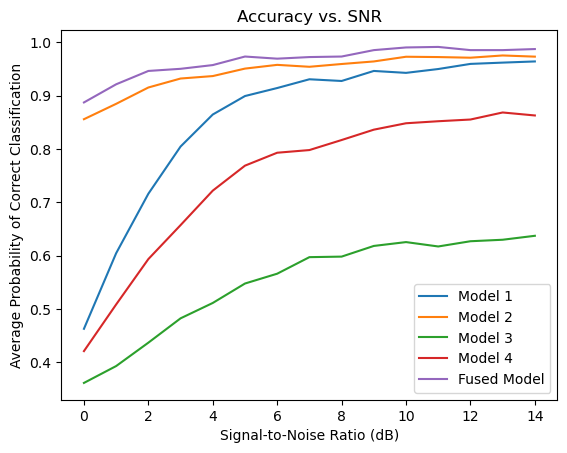

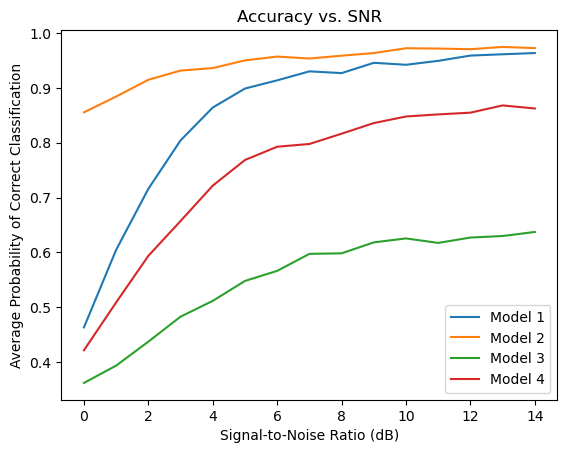

In [10]:
team1_snr_dir = os.path.join(team1_test_dir, 'snr')
team2_snr_dir = os.path.join(team2_test_dir, 'snr')
team3_snr_dir = os.path.join(team3_test_dir, 'snr')
team4_snr_dir = os.path.join(team4_test_dir, 'snr')

snr_folder_names = []
processed_snrs = []
team1_accuracies = []
team2_accuracies = []
team3_accuracies = []
team4_accuracies = []
fused_accuracies = []

# Iterate over every folder in the SNR directory
for path, subdirs, files in os.walk(team1_snr_dir):
    # If we're in the top-level SNR directory, get the values from all the folder names
    if os.path.basename(path) == 'snr':
        snr_folder_names = subdirs
    elif os.path.basename(path) in snr_folder_names:
        snr = int(os.path.basename(path))
        
        # Load the IQ and label data for this SNR
        labels = load_labels(path, 1, num_batches, num_examples, MODELS_OBS_INT).numpy()
        team1_dataloader = load_data(os.path.join(team1_snr_dir, str(snr)), 1, num_batches, num_examples, TEAM1_OBS_INT)
        team2_dataloader = load_data(os.path.join(team2_snr_dir, str(snr)), 1, num_batches, num_examples, TEAM2_OBS_INT)
        team3_dataloader = load_data(os.path.join(team3_snr_dir, str(snr)), 1, num_batches, num_examples, TEAM3_OBS_INT)
        team4_dataloader = load_data(os.path.join(team4_snr_dir, str(snr)), 1, num_batches, num_examples, TEAM4_OBS_INT)
        print(f'Loaded data for SNR {snr}')
        
        count_all_zeros = 0
        labels = np.squeeze(labels)
        for i in range(len(labels)):
            if np.sum(labels[i]) == 0:
                count_all_zeros += 1
        print("Number of missing labels:", count_all_zeros)
        labels = np.argmax(labels, axis=1)
        
        print('Processing data...')
        # Extract features from Team 1's model
        team1_selected_layer.register_forward_hook(get_features('feats'))
        team1_model.to(device)
        team1_feats_list = []
        team1_preds_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team1_dataloader), desc='Team 1'):
            with torch.inference_mode():
                team1_preds_list.append(np.argmax(team1_model(inputs.to(device)).cpu().numpy(), axis=1)[0])
            team1_feats_list.append(features['feats'].cpu().numpy())
        team1_feats_list = np.concatenate(team1_feats_list)
        features1 = np.array(team1_feats_list)
        features1 = torch.tensor(features1)
        features1 = features1.reshape(-1, features1.shape[-1])
        if features1.shape[1] != NUM_FEATS_T1:
            print(f'Error: Number of features extracted from team 1 model doesn\'t match expected value ({NUM_FEATS_T1})')
                
        # Extract features from Team 2's model
        team2_selected_layer.register_forward_hook(get_features('feats'))
        team2_model.to(device)
        team2_feats_list = []
        team2_preds_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team2_dataloader), desc='Team 2'):
            with torch.inference_mode():
                team2_preds_list.append(np.argmax(team2_model(inputs.to(device)).cpu().numpy(), axis=1)[0])
            team2_feats_list.append(features['feats'].cpu().numpy())
        team2_feats_list = np.concatenate(team2_feats_list)
        features2 = np.array(team2_feats_list)
        features2 = torch.tensor(features2)
        features2 = features2.reshape(-1, features2.shape[-1])
        if features2.shape[1] != NUM_FEATS_T2:
            print(f'Error: Number of features extracted from team 2 model doesn\'t match expected value ({NUM_FEATS_T2})')
        
        # Extract features from Team 3's model
        team3_selected_layer.register_forward_hook(get_features('feats'))
        team3_model.to(device)
        team3_feats_list = []
        team3_preds_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team3_dataloader), desc='Team 3'):
            with torch.inference_mode():
                team3_preds_list.append(np.argmax(team3_model(inputs.to(device)).cpu().numpy(), axis=1)[0])
            team3_feats_list.append(features['feats'].cpu().numpy())
        team3_feats_list = np.concatenate(team3_feats_list)
        features3 = np.array(team3_feats_list)
        features3 = torch.tensor(features3)
        features3 = features3.reshape(-1, features3.shape[-1])
        if features3.shape[1] != NUM_FEATS_T3:
            print(f'Error: Number of features extracted from team 3 model doesn\'t match expected value ({NUM_FEATS_T3})')
        
        # Extract features from team 4's model
        team4_selected_layer.register_forward_hook(get_features('feats'))
        team4_model.to(device)
        team4_feats_list = []
        team4_preds_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team4_dataloader), desc='Team 4'):
            with torch.inference_mode():
                team4_preds_list.append(np.argmax(team4_model(inputs.to(device)).cpu().numpy(), axis=1)[0])
            team4_feats_list.append(features['feats'].cpu().numpy())
        team4_feats_list = np.concatenate(team4_feats_list)
        features4 = np.array(team4_feats_list)
        features4 = torch.tensor(features4)
        features4 = features4.reshape(-1, features4.shape[-1])
        if features4.shape[1] != NUM_FEATS_T4:
            print(f'Error: Number of features extracted from team 4 model doesn\'t match expected value ({NUM_FEATS_T4})')
        
        combined_tensor = torch.cat((features1, features2, features3, features4), dim=1)
        
        # Create baseline fused model
        train_data, validation_data, train_labels, validation_labels = train_test_split(combined_tensor, labels, test_size=0.2)
        fused_model = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2, n_estimators=5)
        fused_model.fit(train_data, train_labels, eval_set=[(validation_data, validation_labels)], verbose=0)

        fused_model_out = fused_model.predict(validation_data)
        num_correct = np.sum(fused_model_out == validation_labels)
        num_validation_labels = validation_labels.shape[0]
        fused_model_accuracy = num_correct / num_validation_labels
        fused_accuracies.append(fused_model_accuracy)
        
        # Get accuracy values
        team1_accuracies.append(np.sum(np.array(team1_preds_list) == labels) / len(labels))
        team2_accuracies.append(np.sum(np.array(team2_preds_list) == labels) / len(labels))
        team3_accuracies.append(np.sum(np.array(team3_preds_list) == labels) / len(labels))
        team4_accuracies.append(np.sum(np.array(team4_preds_list) == labels) / len(labels))
            
        processed_snrs.append(snr)

# Create the accuracy plots
df = pd.DataFrame(
    {'snr': processed_snrs,
        'Model 1': team1_accuracies,
        'Model 2': team2_accuracies,
        'Model 3': team3_accuracies,
        'Model 4': team4_accuracies,
        'Fused Model': fused_accuracies
    })
df.sort_values(by=['snr'], inplace=True)
df.plot.line(x='snr')

plt.ylabel('Average Probability of Correct Classification')
plt.xlabel('Signal-to-Noise Ratio (dB)')
plt.title('Accuracy vs. SNR')
plt.savefig('../data/fusion_plots/accuracy_vs_nuisance_params/snr_with_fused.png')
plt.show()

df = pd.DataFrame(
    {'snr': processed_snrs,
        'Model 1': team1_accuracies,
        'Model 2': team2_accuracies,
        'Model 3': team3_accuracies,
        'Model 4': team4_accuracies
    })
df.sort_values(by=['snr'], inplace=True)
df.plot.line(x='snr')
plt.ylabel('Average Probability of Correct Classification')
plt.xlabel('Signal-to-Noise Ratio (dB)')
plt.title('Accuracy vs. SNR')
plt.savefig('../data/fusion_plots/accuracy_vs_nuisance_params/snr.png')
plt.show()


## Plot accuracy vs bandwidth

Found 4 rows containing NaNs in ../data/dataset/team3/test/bandwidths/0.095/iqdata/example_1.dat
Found 4 rows containing NaNs in ../data/dataset/team4/test/bandwidths/0.095/iqdata/example_1.dat
Loaded data for bandwidth 0.095
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2522.21it/s]
Team 2: 5000it [00:03, 1315.68it/s]
Team 3: 5000it [00:01, 4003.77it/s]
Team 4: 5000it [00:01, 2503.01it/s]


Loaded data for bandwidth 0.41
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2888.49it/s]
Team 2: 5000it [00:02, 2248.79it/s]
Team 3: 5000it [00:01, 3628.73it/s]
Team 4: 5000it [00:01, 2561.56it/s]


Found 1 rows containing NaNs in ../data/dataset/team4/test/bandwidths/0.11750000000000001/iqdata/example_1.dat
Loaded data for bandwidth 0.11750000000000001
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2853.46it/s]
Team 2: 5000it [00:02, 2167.50it/s]
Team 3: 5000it [00:01, 4118.94it/s]
Team 4: 5000it [00:02, 2473.18it/s]


Found 10 rows containing NaNs in ../data/dataset/team3/test/bandwidths/0.05/iqdata/example_1.dat
Found 10 rows containing NaNs in ../data/dataset/team4/test/bandwidths/0.05/iqdata/example_1.dat
Loaded data for bandwidth 0.05
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2899.07it/s]
Team 2: 5000it [00:02, 2235.15it/s]
Team 3: 5000it [00:01, 4184.69it/s]
Team 4: 5000it [00:01, 2539.89it/s]


Loaded data for bandwidth 0.2975
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2866.70it/s]
Team 2: 5000it [00:03, 1606.35it/s]
Team 3: 5000it [00:01, 4100.67it/s]
Team 4: 5000it [00:01, 2527.20it/s]


Loaded data for bandwidth 0.27499999999999997
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2853.67it/s]
Team 2: 5000it [00:02, 2245.82it/s]
Team 3: 5000it [00:01, 4153.04it/s]
Team 4: 5000it [00:01, 2541.39it/s]


Found 1 rows containing NaNs in ../data/dataset/team4/test/bandwidths/0.185/iqdata/example_1.dat
Loaded data for bandwidth 0.185
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2876.04it/s]
Team 2: 5000it [00:02, 2235.96it/s]
Team 3: 5000it [00:01, 4149.80it/s]
Team 4: 5000it [00:01, 2563.61it/s]


Loaded data for bandwidth 0.5
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2845.03it/s]
Team 2: 5000it [00:02, 2266.32it/s]
Team 3: 5000it [00:01, 4037.09it/s]
Team 4: 5000it [00:01, 2569.59it/s]


Loaded data for bandwidth 0.4775
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 1882.90it/s]
Team 2: 5000it [00:02, 2234.31it/s]
Team 3: 5000it [00:01, 4026.53it/s]
Team 4: 5000it [00:01, 2546.45it/s]


Loaded data for bandwidth 0.20750000000000002
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2812.32it/s]
Team 2: 5000it [00:02, 2208.04it/s]
Team 3: 5000it [00:01, 4129.49it/s]
Team 4: 5000it [00:01, 2551.10it/s]


Found 2 rows containing NaNs in ../data/dataset/team3/test/bandwidths/0.07250000000000001/iqdata/example_1.dat
Found 5 rows containing NaNs in ../data/dataset/team4/test/bandwidths/0.07250000000000001/iqdata/example_1.dat
Loaded data for bandwidth 0.07250000000000001
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2825.14it/s]
Team 2: 5000it [00:03, 1593.50it/s]
Team 3: 5000it [00:02, 2206.26it/s]
Team 4: 5000it [00:02, 2406.73it/s]


Loaded data for bandwidth 0.2525
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2850.46it/s]
Team 2: 5000it [00:02, 2213.53it/s]
Team 3: 5000it [00:01, 4014.23it/s]
Team 4: 5000it [00:01, 2583.77it/s]


Loaded data for bandwidth 0.32
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2674.08it/s]
Team 2: 5000it [00:02, 2218.23it/s]
Team 3: 5000it [00:01, 2610.07it/s]
Team 4: 5000it [00:01, 2578.62it/s]


Loaded data for bandwidth 0.22999999999999998
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2871.38it/s]
Team 2: 5000it [00:03, 1624.83it/s]
Team 3: 5000it [00:01, 3995.58it/s]
Team 4: 5000it [00:01, 2550.45it/s]


Found 1 rows containing NaNs in ../data/dataset/team4/test/bandwidths/0.14/iqdata/example_1.dat
Loaded data for bandwidth 0.14
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2845.03it/s]
Team 2: 5000it [00:03, 1594.49it/s]
Team 3: 5000it [00:01, 4112.10it/s]
Team 4: 5000it [00:01, 2550.00it/s]


Loaded data for bandwidth 0.365
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2881.81it/s]
Team 2: 5000it [00:02, 2259.18it/s]
Team 3: 5000it [00:02, 2194.46it/s]
Team 4: 5000it [00:02, 2290.85it/s]


Loaded data for bandwidth 0.34249999999999997
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2893.72it/s]
Team 2: 5000it [00:02, 2281.91it/s]
Team 3: 5000it [00:01, 4144.87it/s]
Team 4: 5000it [00:01, 2590.88it/s]


Loaded data for bandwidth 0.16249999999999998
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2922.72it/s]
Team 2: 5000it [00:02, 2247.66it/s]
Team 3: 5000it [00:01, 3084.69it/s]
Team 4: 5000it [00:01, 2559.13it/s]


Loaded data for bandwidth 0.4325
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2549.94it/s]
Team 2: 5000it [00:02, 2225.31it/s]
Team 3: 5000it [00:01, 4061.71it/s]
Team 4: 5000it [00:01, 2520.96it/s]


Loaded data for bandwidth 0.38749999999999996
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2885.89it/s]
Team 2: 5000it [00:02, 2250.33it/s]
Team 3: 5000it [00:01, 4066.70it/s]
Team 4: 5000it [00:01, 2572.04it/s]


Loaded data for bandwidth 0.45499999999999996
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2899.34it/s]
Team 2: 5000it [00:02, 2245.59it/s]
Team 3: 5000it [00:01, 4038.90it/s]
Team 4: 5000it [00:01, 2577.88it/s]


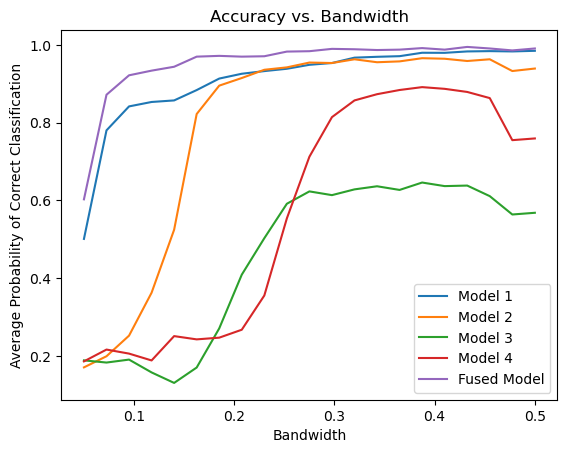

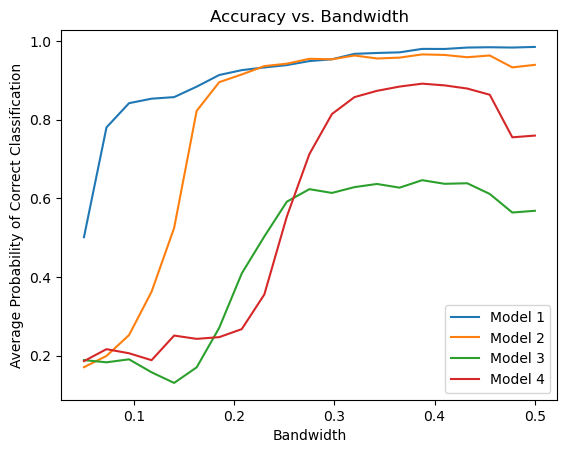

In [11]:
team1_bandwidth_dir = os.path.join(team1_test_dir, 'bandwidths')
team2_bandwidth_dir = os.path.join(team2_test_dir, 'bandwidths')
team3_bandwidth_dir = os.path.join(team3_test_dir, 'bandwidths')
team4_bandwidth_dir = os.path.join(team4_test_dir, 'bandwidths')

bandwidth_folder_names = []
processed_bandwidths = []
team1_accuracies = []
team2_accuracies = []
team3_accuracies = []
team4_accuracies = []
fused_accuracies = []

# Iterate over every folder in the bandwidth directory
for path, subdirs, files in os.walk(team1_bandwidth_dir):
    # If we're in the top-level bandwidth directory, get the values from all the folder names
    if os.path.basename(path) == 'bandwidths':
        bandwidth_folder_names = subdirs
    elif os.path.basename(path) in bandwidth_folder_names:
        bandwidth = float(os.path.basename(path))
        
        # Load the IQ and label data for this bandwidth
        labels = load_labels(path, 1, num_batches, num_examples, MODELS_OBS_INT).numpy()
        team1_dataloader = load_data(os.path.join(team1_bandwidth_dir, str(bandwidth)), 1, num_batches, num_examples, TEAM1_OBS_INT)
        team2_dataloader = load_data(os.path.join(team2_bandwidth_dir, str(bandwidth)), 1, num_batches, num_examples, TEAM2_OBS_INT)
        team3_dataloader = load_data(os.path.join(team3_bandwidth_dir, str(bandwidth)), 1, num_batches, num_examples, TEAM3_OBS_INT)
        team4_dataloader = load_data(os.path.join(team4_bandwidth_dir, str(bandwidth)), 1, num_batches, num_examples, TEAM4_OBS_INT)
        print(f'Loaded data for bandwidth {bandwidth}')
        
        count_all_zeros = 0
        labels = np.squeeze(labels)
        for i in range(len(labels)):
            if np.sum(labels[i]) == 0:
                count_all_zeros += 1
        print("Number of missing labels:", count_all_zeros)
        labels = np.argmax(labels, axis=1)
        
        print('Processing data...')
        # Extract features from Team 1's model
        team1_selected_layer.register_forward_hook(get_features('feats'))
        team1_model.to(device)
        team1_feats_list = []
        team1_preds_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team1_dataloader), desc='Team 1'):
            with torch.inference_mode():
                team1_preds_list.append(np.argmax(team1_model(inputs.to(device)).cpu().numpy(), axis=1)[0])
            team1_feats_list.append(features['feats'].cpu().numpy())
        team1_feats_list = np.concatenate(team1_feats_list)
        features1 = np.array(team1_feats_list)
        features1 = torch.tensor(features1)
        features1 = features1.reshape(-1, features1.shape[-1])
        if features1.shape[1] != NUM_FEATS_T1:
            print(f'Error: Number of features extracted from team 1 model doesn\'t match expected value ({NUM_FEATS_T1})')
                
        # Extract features from Team 2's model
        team2_selected_layer.register_forward_hook(get_features('feats'))
        team2_model.to(device)
        team2_feats_list = []
        team2_preds_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team2_dataloader), desc='Team 2'):
            with torch.inference_mode():
                team2_preds_list.append(np.argmax(team2_model(inputs.to(device)).cpu().numpy(), axis=1)[0])
            team2_feats_list.append(features['feats'].cpu().numpy())
        team2_feats_list = np.concatenate(team2_feats_list)
        features2 = np.array(team2_feats_list)
        features2 = torch.tensor(features2)
        features2 = features2.reshape(-1, features2.shape[-1])
        if features2.shape[1] != NUM_FEATS_T2:
            print(f'Error: Number of features extracted from team 2 model doesn\'t match expected value ({NUM_FEATS_T2})')
        
        # Extract features from Team 3's model
        team3_selected_layer.register_forward_hook(get_features('feats'))
        team3_model.to(device)
        team3_feats_list = []
        team3_preds_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team3_dataloader), desc='Team 3'):
            with torch.inference_mode():
                team3_preds_list.append(np.argmax(team3_model(inputs.to(device)).cpu().numpy(), axis=1)[0])
            team3_feats_list.append(features['feats'].cpu().numpy())
        team3_feats_list = np.concatenate(team3_feats_list)
        features3 = np.array(team3_feats_list)
        features3 = torch.tensor(features3)
        features3 = features3.reshape(-1, features3.shape[-1])
        if features3.shape[1] != NUM_FEATS_T3:
            print(f'Error: Number of features extracted from team 3 model doesn\'t match expected value ({NUM_FEATS_T3})')
        
        # Extract features from team 4's model
        team4_selected_layer.register_forward_hook(get_features('feats'))
        team4_model.to(device)
        team4_feats_list = []
        team4_preds_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team4_dataloader), desc='Team 4'):
            with torch.inference_mode():
                team4_preds_list.append(np.argmax(team4_model(inputs.to(device)).cpu().numpy(), axis=1)[0])
            team4_feats_list.append(features['feats'].cpu().numpy())
        team4_feats_list = np.concatenate(team4_feats_list)
        features4 = np.array(team4_feats_list)
        features4 = torch.tensor(features4)
        features4 = features4.reshape(-1, features4.shape[-1])
        if features4.shape[1] != NUM_FEATS_T4:
            print(f'Error: Number of features extracted from team 4 model doesn\'t match expected value ({NUM_FEATS_T4})')
        
        combined_tensor = torch.cat((features1, features2, features3, features4), dim=1)
        
        # Create baseline fused model
        train_data, validation_data, train_labels, validation_labels = train_test_split(combined_tensor, labels, test_size=0.2)
        fused_model = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2, n_estimators=5)
        fused_model.fit(train_data, train_labels, eval_set=[(validation_data, validation_labels)], verbose=0)

        fused_model_out = fused_model.predict(validation_data)
        num_correct = np.sum(fused_model_out == validation_labels)
        num_validation_labels = validation_labels.shape[0]
        fused_model_accuracy = num_correct / num_validation_labels
        fused_accuracies.append(fused_model_accuracy)
        
        # Get accuracy values
        team1_accuracies.append(np.sum(np.array(team1_preds_list) == labels) / len(labels))
        team2_accuracies.append(np.sum(np.array(team2_preds_list) == labels) / len(labels))
        team3_accuracies.append(np.sum(np.array(team3_preds_list) == labels) / len(labels))
        team4_accuracies.append(np.sum(np.array(team4_preds_list) == labels) / len(labels))
            
        processed_bandwidths.append(bandwidth)

# Create the accuracy plots
df = pd.DataFrame(
    {'bandwidth': processed_bandwidths,
        'Model 1': team1_accuracies,
        'Model 2': team2_accuracies,
        'Model 3': team3_accuracies,
        'Model 4': team4_accuracies,
        'Fused Model': fused_accuracies
    })
df.sort_values(by=['bandwidth'], inplace=True)
df.plot.line(x='bandwidth')

plt.ylabel('Average Probability of Correct Classification')
plt.xlabel('Bandwidth')
plt.title('Accuracy vs. Bandwidth')
plt.savefig('../data/fusion_plots/accuracy_vs_nuisance_params/bandwidth_with_fused.png')
plt.show()

df = pd.DataFrame(
    {'bandwidth': processed_bandwidths,
        'Model 1': team1_accuracies,
        'Model 2': team2_accuracies,
        'Model 3': team3_accuracies,
        'Model 4': team4_accuracies
    })
df.sort_values(by=['bandwidth'], inplace=True)
df.plot.line(x='bandwidth')

plt.ylabel('Average Probability of Correct Classification')
plt.xlabel('Bandwidth')
plt.title('Accuracy vs. Bandwidth')
plt.savefig('../data/fusion_plots/accuracy_vs_nuisance_params/bandwidth.png')
plt.show()

## Plot accuracy vs center frequency

In [ ]:
folder_version = 'cent_freqs'

team1_cf_dir = os.path.join(team1_test_dir, folder_version)
team2_cf_dir = os.path.join(team2_test_dir, folder_version)
team3_cf_dir = os.path.join(team3_test_dir, folder_version)
team4_cf_dir = os.path.join(team4_test_dir, folder_version)

cf_folder_names = []
processed_cfs = []
team1_accuracies = []
team2_accuracies = []
team3_accuracies = []
team4_accuracies = []
fused_accuracies = []

# Iterate over every folder in the center frequencies directory
for path, subdirs, files in os.walk(team1_cf_dir):
    # If we're in the top-level center frequency directory, get the values from all the folder names
    if os.path.basename(path) == folder_version:
        cf_folder_names = subdirs
    elif os.path.basename(path) in cf_folder_names:
        cf = float(os.path.basename(path))
        
        # Load the IQ and label data for this center frequency
        labels = load_labels(path, 1, num_batches, num_examples, MODELS_OBS_INT).numpy()
        team1_dataloader = load_data(os.path.join(team1_cf_dir, str(cf)), 1, num_batches, num_examples, TEAM1_OBS_INT)
        team2_dataloader = load_data(os.path.join(team2_cf_dir, str(cf)), 1, num_batches, num_examples, TEAM2_OBS_INT)
        team3_dataloader = load_data(os.path.join(team3_cf_dir, str(cf)), 1, num_batches, num_examples, TEAM3_OBS_INT)
        team4_dataloader = load_data(os.path.join(team4_cf_dir, str(cf)), 1, num_batches, num_examples, TEAM4_OBS_INT)
        print(f'Loaded data for center frequency {cf}')
        
        count_all_zeros = 0
        labels = np.squeeze(labels)
        for i in range(len(labels)):
            if np.sum(labels[i]) == 0:
                count_all_zeros += 1
        print("Number of missing labels:", count_all_zeros)
        labels = np.argmax(labels, axis=1)
        
        print('Processing data...')
        # Extract features from Team 1's model
        team1_selected_layer.register_forward_hook(get_features('feats'))
        team1_model.to(device)
        team1_feats_list = []
        team1_preds_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team1_dataloader), desc='Team 1'):
            with torch.inference_mode():
                team1_preds_list.append(np.argmax(team1_model(inputs.to(device)).cpu().numpy(), axis=1)[0])
            team1_feats_list.append(features['feats'].cpu().numpy())
        team1_feats_list = np.concatenate(team1_feats_list)
        features1 = np.array(team1_feats_list)
        features1 = torch.tensor(features1)
        features1 = features1.reshape(-1, features1.shape[-1])
        if features1.shape[1] != NUM_FEATS_T1:
            print(f'Error: Number of features extracted from team 1 model doesn\'t match expected value ({NUM_FEATS_T1})')
                
        # Extract features from Team 2's model
        team2_selected_layer.register_forward_hook(get_features('feats'))
        team2_model.to(device)
        team2_feats_list = []
        team2_preds_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team2_dataloader), desc='Team 2'):
            with torch.inference_mode():
                team2_preds_list.append(np.argmax(team2_model(inputs.to(device)).cpu().numpy(), axis=1)[0])
            team2_feats_list.append(features['feats'].cpu().numpy())
        team2_feats_list = np.concatenate(team2_feats_list)
        features2 = np.array(team2_feats_list)
        features2 = torch.tensor(features2)
        features2 = features2.reshape(-1, features2.shape[-1])
        if features2.shape[1] != NUM_FEATS_T2:
            print(f'Error: Number of features extracted from team 2 model doesn\'t match expected value ({NUM_FEATS_T2})')
        
        # Extract features from Team 3's model
        team3_selected_layer.register_forward_hook(get_features('feats'))
        team3_model.to(device)
        team3_feats_list = []
        team3_preds_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team3_dataloader), desc='Team 3'):
            with torch.inference_mode():
                team3_preds_list.append(np.argmax(team3_model(inputs.to(device)).cpu().numpy(), axis=1)[0])
            team3_feats_list.append(features['feats'].cpu().numpy())
        team3_feats_list = np.concatenate(team3_feats_list)
        features3 = np.array(team3_feats_list)
        features3 = torch.tensor(features3)
        features3 = features3.reshape(-1, features3.shape[-1])
        if features3.shape[1] != NUM_FEATS_T3:
            print(f'Error: Number of features extracted from team 3 model doesn\'t match expected value ({NUM_FEATS_T3})')
        
        # Extract features from team 4's model
        team4_selected_layer.register_forward_hook(get_features('feats'))
        team4_model.to(device)
        team4_feats_list = []
        team4_preds_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team4_dataloader), desc='Team 4'):
            with torch.inference_mode():
                team4_preds_list.append(np.argmax(team4_model(inputs.to(device)).cpu().numpy(), axis=1)[0])
            team4_feats_list.append(features['feats'].cpu().numpy())
        team4_feats_list = np.concatenate(team4_feats_list)
        features4 = np.array(team4_feats_list)
        features4 = torch.tensor(features4)
        features4 = features4.reshape(-1, features4.shape[-1])
        if features4.shape[1] != NUM_FEATS_T4:
            print(f'Error: Number of features extracted from team 4 model doesn\'t match expected value ({NUM_FEATS_T4})')
        
        combined_tensor = torch.cat((features1, features2, features3, features4), dim=1)
        
        # Create baseline fused model
        train_data, validation_data, train_labels, validation_labels = train_test_split(combined_tensor, labels, test_size=0.2)
        fused_model = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2, n_estimators=5)
        fused_model.fit(train_data, train_labels, eval_set=[(validation_data, validation_labels)], verbose=0)

        fused_model_out = fused_model.predict(validation_data)
        num_correct = np.sum(fused_model_out == validation_labels)
        num_validation_labels = validation_labels.shape[0]
        fused_model_accuracy = num_correct / num_validation_labels
        fused_accuracies.append(fused_model_accuracy)
        
        # Get accuracy values
        team1_accuracies.append(np.sum(np.array(team1_preds_list) == labels) / len(labels))
        team2_accuracies.append(np.sum(np.array(team2_preds_list) == labels) / len(labels))
        team3_accuracies.append(np.sum(np.array(team3_preds_list) == labels) / len(labels))
        team4_accuracies.append(np.sum(np.array(team4_preds_list) == labels) / len(labels))
            
        processed_cfs.append(cf)

# Create the accuracy plots
df = pd.DataFrame(
    {'cf': processed_cfs,
        'Model 1': team1_accuracies,
        'Model 2': team2_accuracies,
        'Model 3': team3_accuracies,
        'Model 4': team4_accuracies,
        'Fused Model': fused_accuracies
    })
df.sort_values(by=['cf'], inplace=True)
df.plot.line(x='cf')
plt.ylabel('Average Probability of Correct Classification')
plt.xlabel('Center Frequency')
plt.title('Accuracy vs. Center Frequency')
plt.savefig('../data/fusion_plots/accuracy_vs_nuisance_params/cent_freq_with_fused.png')
plt.show()

df = pd.DataFrame(
    {'cf': processed_cfs,
        'Model 1': team1_accuracies,
        'Model 2': team2_accuracies,
        'Model 3': team3_accuracies,
        'Model 4': team4_accuracies
    })
df.sort_values(by=['cf'], inplace=True)
df.plot.line(x='cf')
plt.ylabel('Average Probability of Correct Classification')
plt.xlabel('Center Frequency')
plt.title('Accuracy vs. Center Frequency')
plt.savefig('../data/fusion_plots/accuracy_vs_nuisance_params/cent_freq.png')
plt.show()

Loaded data for center frequency -0.08
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2889.94it/s]
Team 2: 5000it [00:02, 2188.45it/s]
Team 3: 5000it [00:01, 4010.68it/s]
Team 4: 5000it [00:01, 2558.74it/s]


Loaded data for center frequency -0.04000000000000001
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2867.81it/s]
Team 2: 5000it [00:02, 2240.21it/s]
Team 3: 5000it [00:01, 2828.72it/s]
Team 4: 5000it [00:01, 2574.05it/s]


Loaded data for center frequency 0.06
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2874.83it/s]
Team 2: 5000it [00:02, 2148.63it/s]
Team 3: 5000it [00:01, 3909.38it/s]
Team 4: 5000it [00:02, 2476.57it/s]


Loaded data for center frequency 0.07
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2881.51it/s]
Team 2: 5000it [00:02, 2204.18it/s]
Team 3: 5000it [00:01, 4010.56it/s]
Team 4: 5000it [00:01, 2557.85it/s]


Loaded data for center frequency 0.009999999999999995
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 1948.51it/s]
Team 2: 5000it [00:02, 1978.83it/s]
Team 3: 5000it [00:01, 3620.42it/s]
Team 4: 5000it [00:02, 2385.91it/s]


Loaded data for center frequency -0.010000000000000009
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 2211.23it/s]
Team 2: 5000it [00:03, 1634.24it/s]
Team 3: 5000it [00:01, 3961.27it/s]
Team 4: 5000it [00:01, 2571.84it/s]


Loaded data for center frequency -0.060000000000000005
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2872.80it/s]
Team 2: 5000it [00:02, 2268.64it/s]
Team 3: 5000it [00:01, 3513.36it/s]
Team 4: 5000it [00:02, 2193.49it/s]


Loaded data for center frequency 0.1
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:02, 1819.27it/s]
Team 2: 5000it [00:03, 1631.58it/s]
Team 3: 5000it [00:01, 3862.49it/s]
Team 4: 5000it [00:02, 2393.64it/s]


Loaded data for center frequency -0.1
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2677.03it/s]
Team 2: 5000it [00:02, 2223.69it/s]
Team 3: 5000it [00:01, 3836.82it/s]
Team 4: 5000it [00:01, 2518.85it/s]


Loaded data for center frequency 0.07999999999999999
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2906.86it/s]
Team 2: 5000it [00:02, 2222.65it/s]
Team 3: 5000it [00:01, 3948.35it/s]
Team 4: 5000it [00:01, 2583.27it/s]


Loaded data for center frequency -0.020000000000000004
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2848.55it/s]
Team 2: 5000it [00:02, 2248.08it/s]
Team 3: 5000it [00:01, 3996.51it/s]
Team 4: 5000it [00:01, 2579.61it/s]


Loaded data for center frequency 0.04999999999999999
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2915.87it/s]
Team 2: 5000it [00:02, 1896.74it/s]
Team 3: 5000it [00:01, 4008.55it/s]
Team 4: 5000it [00:01, 2549.72it/s]


Loaded data for center frequency -0.03
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2847.20it/s]
Team 2: 5000it [00:02, 1840.98it/s]
Team 3: 5000it [00:01, 3870.47it/s]
Team 4: 5000it [00:02, 2157.31it/s]


Loaded data for center frequency -0.07
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2925.29it/s]
Team 2: 5000it [00:02, 2228.02it/s]
Team 3: 5000it [00:01, 3945.71it/s]
Team 4: 5000it [00:02, 2397.98it/s]


Loaded data for center frequency -0.05
Number of missing labels: 0
Processing data...


Team 1: 5000it [00:01, 2910.76it/s]
Team 2: 5000it [00:02, 2246.69it/s]
Team 3: 2914it [00:00, 2566.79it/s]

## Plot accuracy vs obs int

In [ ]:
team1_obs_dir = os.path.join(team1_test_dir, 'obs_ints')
team2_obs_dir = os.path.join(team2_test_dir, 'obs_ints')
team3_obs_dir = os.path.join(team3_test_dir, 'obs_ints')
team4_obs_dir = os.path.join(team4_test_dir, 'obs_ints')

obs_folder_names = []
processed_obs = []
team1_accuracies = []
team2_accuracies = []
team3_accuracies = []
team4_accuracies = []
fused_accuracies = []

# Iterate over every folder in the obs ints directory
for path, subdirs, files in os.walk(team1_obs_dir):
    # If we're in the top-level obs int directory, get the values from all the folder names
    if os.path.basename(path) == 'obs_ints':
        obs_folder_names = subdirs
    elif os.path.basename(path) in obs_folder_names:
        obs = int(os.path.basename(path))
        
        # Load the IQ and label data for this obs int
        labels = load_labels(path, 1, num_batches, num_examples, MODELS_OBS_INT).numpy()
        team1_dataloader = load_data(os.path.join(team1_obs_dir, str(obs)), 1, num_batches, num_examples, obs)
        team2_dataloader = load_data(os.path.join(team2_obs_dir, str(obs)), 1, num_batches, num_examples, obs)
        team3_dataloader = load_data(os.path.join(team3_obs_dir, str(obs)), 1, num_batches, num_examples, obs)
        team4_dataloader = load_data(os.path.join(team4_obs_dir, str(obs)), 1, num_batches, num_examples, obs)
        print(f'Loaded data for obs int {obs}')
        
        count_all_zeros = 0
        labels = np.squeeze(labels)
        for i in range(len(labels)):
            if np.sum(labels[i]) == 0:
                count_all_zeros += 1
        print("Number of missing labels:", count_all_zeros)
        labels = np.argmax(labels, axis=1)
        
        print('Processing data...')
        # Extract features from Team 1's model
        team1_selected_layer.register_forward_hook(get_features('feats'))
        team1_model.to(device)
        team1_feats_list = []
        team1_preds_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team1_dataloader), desc='Team 1'):
            with torch.inference_mode():
                team1_preds_list.append(np.argmax(team1_model(inputs.to(device)).cpu().numpy(), axis=1)[0])
            team1_feats_list.append(features['feats'].cpu().numpy())
        team1_feats_list = np.concatenate(team1_feats_list)
        features1 = np.array(team1_feats_list)
        features1 = torch.tensor(features1)
        features1 = features1.reshape(-1, features1.shape[-1])
        if features1.shape[1] != NUM_FEATS_T1:
            print(f'Error: Number of features extracted from team 1 model doesn\'t match expected value ({NUM_FEATS_T1})')
                
        # Extract features from Team 2's model
        team2_selected_layer.register_forward_hook(get_features('feats'))
        team2_model.to(device)
        team2_feats_list = []
        team2_preds_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team2_dataloader), desc='Team 2'):
            with torch.inference_mode():
                team2_preds_list.append(np.argmax(team2_model(inputs.to(device)).cpu().numpy(), axis=1)[0])
            team2_feats_list.append(features['feats'].cpu().numpy())
        team2_feats_list = np.concatenate(team2_feats_list)
        features2 = np.array(team2_feats_list)
        features2 = torch.tensor(features2)
        features2 = features2.reshape(-1, features2.shape[-1])
        if features2.shape[1] != NUM_FEATS_T2:
            print(f'Error: Number of features extracted from team 2 model doesn\'t match expected value ({NUM_FEATS_T2})')
        
        # Extract features from Team 3's model
        team3_selected_layer.register_forward_hook(get_features('feats'))
        team3_model.to(device)
        team3_feats_list = []
        team3_preds_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team3_dataloader), desc='Team 3'):
            with torch.inference_mode():
                team3_preds_list.append(np.argmax(team3_model(inputs.to(device)).cpu().numpy(), axis=1)[0])
            team3_feats_list.append(features['feats'].cpu().numpy())
        team3_feats_list = np.concatenate(team3_feats_list)
        features3 = np.array(team3_feats_list)
        features3 = torch.tensor(features3)
        features3 = features3.reshape(-1, features3.shape[-1])
        if features3.shape[1] != NUM_FEATS_T3:
            print(f'Error: Number of features extracted from team 3 model doesn\'t match expected value ({NUM_FEATS_T3})')
        
        # Extract features from team 4's model
        team4_selected_layer.register_forward_hook(get_features('feats'))
        team4_model.to(device)
        team4_feats_list = []
        team4_preds_list = []
        features = {}
        # Feed the IQ data into the model
        for idx, inputs in tqdm(enumerate(team4_dataloader), desc='Team 4'):
            with torch.inference_mode():
                team4_preds_list.append(np.argmax(team4_model(inputs.to(device)).cpu().numpy(), axis=1)[0])
            team4_feats_list.append(features['feats'].cpu().numpy())
        team4_feats_list = np.concatenate(team4_feats_list)
        features4 = np.array(team4_feats_list)
        features4 = torch.tensor(features4)
        features4 = features4.reshape(-1, features4.shape[-1])
        if features4.shape[1] != NUM_FEATS_T4:
            print(f'Error: Number of features extracted from team 4 model doesn\'t match expected value ({NUM_FEATS_T4})')
        
        combined_tensor = torch.cat((features1, features2, features3, features4), dim=1)
        
        # Create baseline fused model
        train_data, validation_data, train_labels, validation_labels = train_test_split(combined_tensor, labels, test_size=0.2)
        fused_model = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2, n_estimators=5)
        fused_model.fit(train_data, train_labels, eval_set=[(validation_data, validation_labels)], verbose=0)

        fused_model_out = fused_model.predict(validation_data)
        num_correct = np.sum(fused_model_out == validation_labels)
        num_validation_labels = validation_labels.shape[0]
        fused_model_accuracy = num_correct / num_validation_labels
        fused_accuracies.append(fused_model_accuracy)
        
        # Get accuracy values
        team1_accuracies.append(np.sum(np.array(team1_preds_list) == labels) / len(labels))
        team2_accuracies.append(np.sum(np.array(team2_preds_list) == labels) / len(labels))
        team3_accuracies.append(np.sum(np.array(team3_preds_list) == labels) / len(labels))
        team4_accuracies.append(np.sum(np.array(team4_preds_list) == labels) / len(labels))
            
        processed_obs.append(obs)

# Create the accuracy plots
df = pd.DataFrame(
    {'obs': processed_obs,
        'Model 1': team1_accuracies,
        'Model 2': team2_accuracies,
        'Model 3': team3_accuracies,
        'Model 4': team4_accuracies,
        'Fused Model': fused_accuracies
    })
df.sort_values(by=['obs'], inplace=True)
df.plot.line(x='obs')
plt.ylabel('Average Probability of Correct Classification')
plt.xlabel('Observation Duration')
plt.title('Accuracy vs. Observation Duration')
plt.savefig('../data/fusion_plots/accuracy_vs_nuisance_params/obs_int_with_fused.png')
plt.show()
    
df = pd.DataFrame(
    {'obs': processed_obs,
        'Model 1': team1_accuracies,
        'Model 2': team2_accuracies,
        'Model 3': team3_accuracies,
        'Model 4': team4_accuracies
    })
df.sort_values(by=['obs'], inplace=True)
df.plot.line(x='obs')
plt.ylabel('Average Probability of Correct Classification')
plt.xlabel('Observation Duration')
plt.title('Accuracy vs. Observation Duration')
plt.savefig('../data/fusion_plots/accuracy_vs_nuisance_params/obs_int.png')
plt.show()